In [1]:
import numpy as np
import scipy.sparse as sps
import sympy

import porepy as pp

# For grid convergence
import matplotlib.pyplot as plt
from porepy.geometry.geometry_property_checks import is_ccw_polyline
from porepy.geometry.geometry_property_checks import is_ccw_polygon
from porepy.geometry.geometry_property_checks import point_in_polygon

In [37]:
def make_points_ccw(p, tol=1e-5):
    """
    Return the points sorted in ccw order.
    
    Sort points in 2D, by ccw order. Not tested for non-convex point sets.
    
    Parameters:
        p (np.ndarray, 2 x n): Points to be sorted.
    
    Returns:
        np.ndarray, ccw sorted list of points.
        
    Steps of algorithm:
    Let poly = p.copy()
    
    CASE I: 3 points provided.
    1. Check if points are collinear.
        - If True: Raise ValueError.
    2. Run is_ccw_polyline(poly) 
        - If True: Return poly
        - Otherwise: Return poly.copy()[:, ::-1]
        
    CASE II: 4 points provided.
    1. Name the points A,B,C,D.
    2. Consider two points, e.g. AB.
    3. Check if any of C and D is collinear to AB.
        a. If any:
            - Raise ValueError
    3. Check that C and D is ccw relative to AB
        a. If both cw: 
            - Continue with XY = BA.
        b. If one cw and one ccw:
            - Continue with XY = AC (or AD, it doesn't matter)
        c. If both ccw: 
            - Continue with XY = AB
    4. Name the other two points Z, W.
    5. Run is_ccw_polygon on XYZW and XYWZ.
        a. Return the case which is True.
        
    CASE III: Number of points provided > 4.
    1. Raise NotYetImplementedError.
    
    """
    
    num_p = p.shape[1]
    poly = p.copy()
    
    assert(num_p > 2) # Need to provide at least 3 points.
    
    # CASE I:
    if num_p == 3:
        A,B,C = poly.T
        if np.abs(np.cross(C-A,B-A)) < tol:
            raise ValueError("Points are collinear.")
        
        if is_ccw_polyline(A,B,C,tol=tol):
            return poly
        else:
            return poly.copy()[:, ::-1]
    
    # CASE II:
    elif num_p == 4:
        A,B,C,D = poly.T
        collC = np.abs(np.cross(C-A,B-A)) < tol
        collD = np.abs(np.cross(D-A,B-A)) < tol
        if collC or collD:
            raise ValueError("Some triples of points are collinear.")
        
        orientations = is_ccw_polyline(A,B,np.array((C,D)).T)
        if np.all(np.logical_not(orientations)):  # Both other pts are cw.
            A,B = B,A
        elif np.any(np.logical_not(orientations)): # Exactly one pt is cw.
            B,C=C,B
        
        # Either ABCD or ABDC is either cw or ccw.
        arr1 = np.array((A,B,C,D)).T
        arr2 = np.array((A,B,D,C)).T
        if is_ccw_polygon(arr1):
            return arr1
        elif is_ccw_polygon(arr1[:, ::-1]):
            return arr1[:, ::-1]
        elif is_ccw_polygon(arr2):
            return arr2
        elif is_ccw_polygon(arr2[:, ::-1]):
            return arr2[:, ::-1]
        else:
            raise Error("An unexpected error occured.")
        
    
    elif num_p > 4:
        raise NotImplemented("Not implemented for larger polygons.")

        
def identify_overlap(gc, gf):
    """
    Method to find overlapping cells in two grids over the same domain (2D).
    
    Parameters:
    gc (porepy.Grid): The coarse grid with Nc number of cells
    gf (porepy.Grid): The fine grid with Nf number of cells
    
    Returns:
    Nf x Nc sparse matrix: If entry (i,j)  contains 1, then cell i in the fine grid 
                           is contained in cell j in the coarse grid.
                            
    """
    
    # cell_nodes is a num_nodes x num_cells sparse column oriented matrix. (sps.csc_matrix).
    ccell_nodes = gc.cell_nodes()
    cnnz = ccell_nodes.nnz
    slices = zip(ccell_nodes.indptr[:-1], ccell_nodes.indptr[1:])
    
    # Create sps.csc_matrix mapping coarse cells to fine cell centers.
    indptr = [0]
    indices = []
    
    for st, nd in slices:  # Loop through every cell.
        nodes = ccell_nodes.indices[st:nd]
        node_coords = np.array(gc.nodes[:,nodes][0:2])
        poly = make_points_ccw(node_coords)
        inside = point_in_polygon(poly, gf.cell_centers)#, tol=1e-5, default=True)
        inside_id = np.array([i for i, x in enumerate(inside) if x])  # Location of the (fine) nodes inside the coarse cell.
        
        indptr.extend([indptr[-1]+len(inside_id)])  # Update index pointer
        indices.extend(inside_id)  # Update indices of fine cells for the current coarse cell.
    
    data = np.ones(len(indices))
    
    ccell_fcell = sps.csc_matrix((data, indices, indptr))
    return ccell_fcell


def grid_convergence(gl,pl,plotting=False):
    """ Compute grid convergence of a set of solutions.
    
    Parameters
    gl (list of pp.Grid): List of N grids (with pre-computed geometries).
    pl (list of np.ndarray): List N of solution vectors.
    
    Returns
    np.ndarray (N-1,): List of errors relative to reference solution.
    float: Slope of the two finest solutions.
    
    Note: Each grid and solution vector should correspond by index in 
        each list. Initially, g and p should be sorted from coarsest to
        finest.

    """
    N = np.zeros(len(pl))
    for i in range(len(N)):
        N[i] = len(pl[i])
    for i in range(len(N)):
        assert(gl[i].num_cells == len(pl[i]))
    for i in range(1,len(N)):
        assert (len(pl[i]) > len(pl[i-1]))
    
    errors = np.ones(len(N)-1)
    
    errors2 = np.ones(len(N)-1)
    errors3 = np.ones(len(N)-1)
    
    sol = [] # Store all solutions
    g_bucket = []  # Store all grids
    
    # Now, map all coarse solution to the fine grid.
    mapped_sol = []
    ref_grid_num_cells = len(pl[-1])
    g_ref = gl[-1]
    ref_sol = pl[-1]
    for i in range(len(N)-1): 
        arr = np.zeros(ref_grid_num_cells)
        g = gl[i]
        p = pl[i]
        
        mapping = identify_overlap(gc=g, gf=g_ref)
        slices = zip(mapping.indptr[:-1], mapping.indptr[1:])
        for j, stnd in enumerate(slices):
            st,nd=stnd
            nodes = mapping.indices[st:nd]
            arr[nodes] = p[j]
            
        mapped_sol.append(arr)
        errors[i] = pp.error.norm_L2(g_ref,arr-ref_sol)
        errors2[i] = pp.error.error_L2(g_ref,arr, ref_sol, relative=True)
        errors3[i] = pp.error.error_L2(g_ref,arr, ref_sol, relative=False)
    print("Relative errors:", errors2)
    print("Absolute errors:", errors3)
    
    # N[-3] over N[-2] because we want to use h=1/N
    # for slope estimation.
    h = 1/np.sqrt(N[:-1])
    slope = np.log(errors2[-1] / errors2[-2]) / np.log(h[-1] / h[-2])
    slope = np.abs(slope)
    slopes = np.ones(len(h)-1)
    for i in range(len(h)-1):
        slopes[i] = np.log(errors[i+1] / errors[i]) / np.log(h[i+1] / h[i])
        
    
    # Plot h=1/N along x-axis
    if plotting:
        plt.loglog(h, errors)
        plt.title(f"Slope: {slope}")
        plt.show()
    
    return errors, slope, slopes

In [44]:
class Flow:
    
    def __init__(self):
        """ Assemble the flow problem
        
        Attributes:
        tol (float): Tolerance for various calculations
        
        """
        self.tol = 1e-10
        
        # The following attributes will be assigned
        # in the process before solving the flow problem:
        self.g = None
        self.N = None
        self.physdims = None
        self.data = None
        self.solver = None
        
    def create_grid(self, N):
        """ Create the domain
        
        The following attributes are assigned to self:
            N (int): Number of cells in each direction
            physdims (np.array): Dimensions of domain
            g (pp.Grid): The grid
        """
        self.N = N
        self.physdims = np.array([1,1])
        n = [N, N]
        g = pp.CartGrid(n, self.physdims)
        g.compute_geometry()
        
        self.g = g
    
    def perturb_grid(self, pert):
        """ Perturb the grid"""
        g = self.g
        tol = self.tol
        physdims = self.physdims
        east = np.ravel(np.argwhere(g.nodes[0] > physdims[0] - tol))
        west = np.ravel(np.argwhere(g.nodes[0] < tol))
        north = np.ravel(np.argwhere(g.nodes[1] > physdims[1] - tol))
        south = np.ravel(np.argwhere(g.nodes[1] < tol))
        
        # Don't move boundary nodes
        move = np.ones(g.num_nodes)
        move[north] = 0
        move[south] = 0
        move[west] = 0
        move[east] = 0
        
        dx = 1/self.N
        rand = np.vstack((np.random.rand(g.dim, g.num_nodes), np.repeat(0., g.num_nodes)))
        g.nodes += pert * dx * (rand - 0.5)*move
        if g.dim == 2:
            g.nodes[2, :] = 0
        g.compute_geometry()
        
    def boundary_conditions(self):
        """ Set boundary conditons.
        
        Left face dirichlet with value 1
        Right face dirichlet with value 0
        Top and bottom face neumann with value 0.
        """
        tol = self.tol
        g = self.g
        
        b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
        labels = np.array(['neu']*b_faces.size)
        
        b_face_centers = g.face_centers[:, b_faces]
        b_inflow = b_face_centers[0, :] < tol
        b_outflow = b_face_centers[0, :] > self.physdims[0] - tol

        labels[np.logical_or(b_inflow, b_outflow)] = "dir"
        
        bc = pp.BoundaryCondition(g, b_faces, labels)
        
        bc_val = np.zeros(g.num_faces)
        bc_val[b_faces[b_inflow]] = 1
        
        return bc, bc_val
    
    def source(self, g):
        """ Set source term"""
        return np.zeros(g.num_cells)
    
    def perm(self, g):
        """ Set permeability"""
        kxx = np.ones(g.num_cells)
        return pp.SecondOrderTensor(kxx)
        
    
    def set_parameters(self):
        """ Set the parameters for the domain."""
        g = self.g
        bc, bc_val = self.boundary_conditions()
        source = self.source(g)
        perm = self.perm(g)
        
        specified_parameters = {'second_order_tensor': perm,
                                 'source': source,
                                 'bc': bc,
                                 'bc_values': bc_val}
        
        data = pp.initialize_default_data(g, {}, "flow", specified_parameters)
        self.data = data
    
    def discretize(self, method):
        """ Discretize the system."""
        
        if method == 'TPFA':
            self.solver = pp.Tpfa("flow")
        elif method == 'MPFA':
            self.solver = pp.Mpfa("flow")
        
        self.solver.discretize(self.g, self.data)
        
        
    def prepare_simulation(self, N, perturb, method):
        """ Run the methods needed to do a simulation
        
        Parameters:
        N (int): Cells in each dimension
        pert (float): Perturbation amount. 0 for no pertubation
        method (str): Currently implemented 'TPFA' and 'MPFA'.
        """
        
        # Create grid
        self.create_grid(N)
        if perturb:
            self.perturb_grid(perturb)
        
        # Set parameters
        self.set_parameters()
        
        # Discretize
        self.discretize(method)
        
    def solve(self):
        """ Solve the problem."""
        A, b = self.solver.assemble_matrix_rhs(self.g, self.data)
        
        # Source term:
        src = pp.ScalarSource('flow')
        src.discretize(self.g, self.data)
        b1 = src.assemble_rhs(self.g, self.data)
        
        x = sps.linalg.spsolve(A, b+b1)
        return x
    
    
def run_method(N, perturb, method):
    """ Run method
    
    Parameters:
    N (int): grid size
    perturb (float): Amount of grid pertubation
    method (str): 'TPFA' or 'MPFA'
    """
    
    # Setup
    setup = Flow()
    setup.prepare_simulation(N, perturb, method)
    
    p = setup.solve()
    
    return p, setup.g
    
    


def run_many(grid_sizes, perturb, method):
    """ Run many iterations. Return solutions and grids.
    
    Parameters:
    grid_sizes (list): List of integers denoting grid size
    perturb (float): Amount of grid pertubation
    method (str): 'TPFA' or 'MPFA'
    """
    N = grid_sizes
    pl = []
    gl = []
    for i in range(len(N)):
        Ni = N[i]
        p, g = run_method(Ni, perturb, method)
        pl.append(p)
        gl.append(g.copy())
    
    return pl, gl
        

def error_plot(pl, gl):
    """ Plot errors and the finest grid."""
    errors, slope, slopes = grid_convergence(gl,pl,plotting=True)
    print("Error vector:", errors)
    
    #pp.plot_grid(gl[-1], pl[-1], figsize=(15,12))
    
    return errors, slope, slopes
    

# Use exact solution
Create a function which uses an exact solution as reference value

In [ ]:
class FlowEx(Flow):
    """ Example class"""
    

    def exact_soln(g):
        # Analytical solution
        
        xc = g.cell_centers
        xf = g.face_centers
        
        x, y = sympy.symbols('x y')
        p = x**2*y**3 #linear pressure should give 0 error
        pi = sympy.lambdify((x, y), p, 'numpy')
        dpx = sympy.diff(p, x)
        dpy = sympy.diff(p, y)
        dpxi = sympy.lambdify((x, y), dpx, 'numpy')
        dpyi = sympy.lambdify((x, y), dpy, 'numpy')
        rhs = -sympy.diff(dpx, x) - sympy.diff(dpy, y)
        self.fi = sympy.lambdify((x, y), rhs, 'numpy') # RHS term
        
        pc_ex = pi(xc[0], xc[1])
        pf_ex = pi(xf[0], xf[1])
        flux_ex = -(g.face_normals[0,:] * dpxi(xf[0], xf[1]) + g.face_normals[1,:]
     
    def source(self, g):
        """ Overwrite source term"""
        fc = self.fi(xc[0, :], xc[1, :])*g.cell_volumes
        return np.zeros(g.num_cells)
  

# Grid convergence


Relative errors: [0.12475943 0.06201169 0.03025861 0.01353206]
Absolute errors: [0.07202769 0.03580137 0.01746928 0.0078125 ]


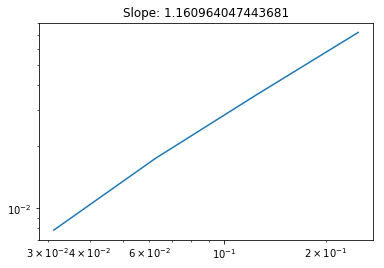

Error vector: [0.07202769 0.03580137 0.01746928 0.0078125 ]


In [45]:
grid_sizes = [4, 8, 16, 32, 64]
perturb = 0
method = 'MPFA'
pl, gl = run_many(grid_sizes, perturb, method)
errors, slope, slopes = error_plot(pl, gl)

In [54]:
np.log2(4/16)

-2.0

In [49]:
El = np.log(errors[-1] / errors[-2])
El

-0.8047189562170499

In [36]:
h=1/np.array(grid_sizes)[:-1]
hl = np.log(h[-1]/h[-2])
hl

-0.6931471805599453

In [8]:
El/hl

1.1609640474436809

# Some sample runs

In [9]:
N=5
perturb=0
method='TPFA'
p, g = run_method(N,perturb,method)

/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


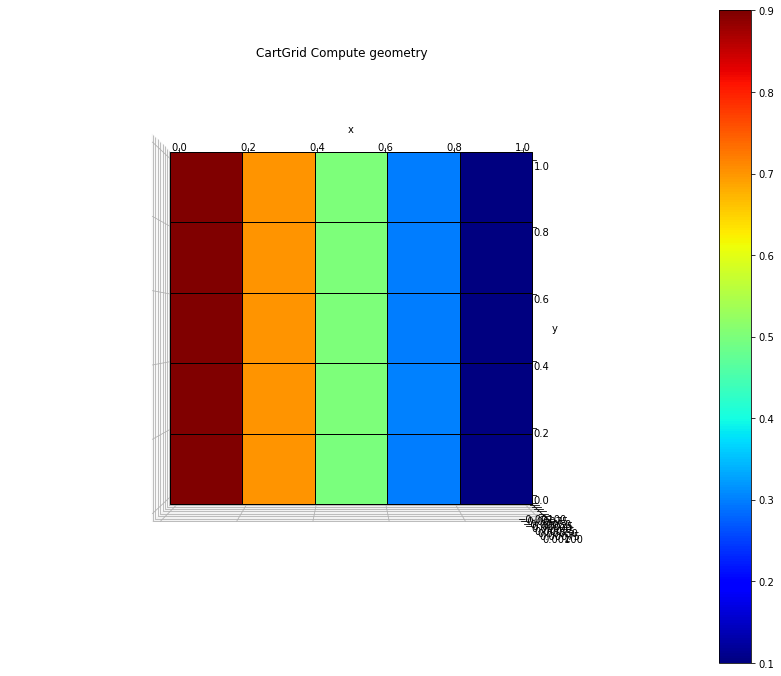

In [10]:
pp.plot_grid(g, p, figsize=(15,12))

/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


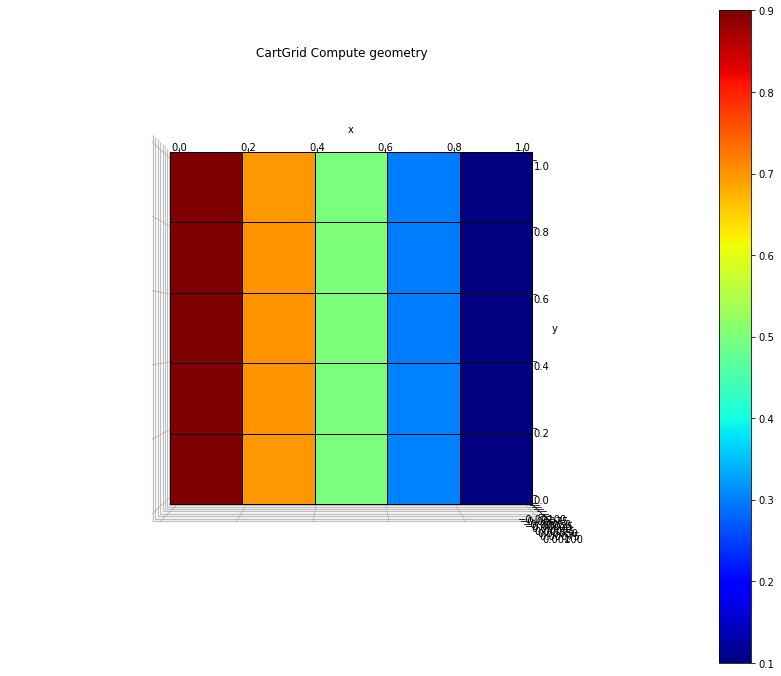

In [11]:
N=5
perturb=0
method='MPFA'
p, g = run_method(N,perturb,method)
pp.plot_grid(g, p, figsize=(15,12))

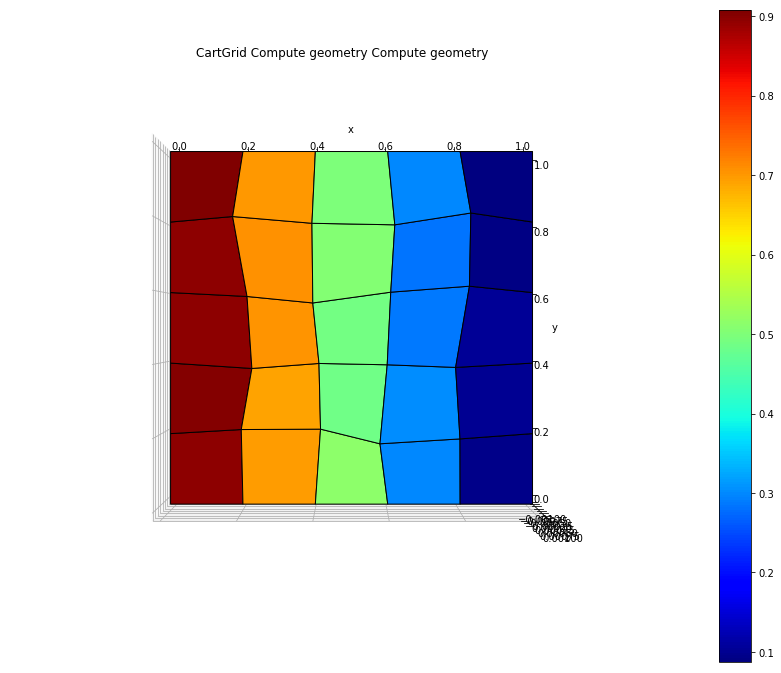

In [12]:
N=5
perturb=0.3
method='TPFA'
p, g = run_method(N,perturb,method)
pp.plot_grid(g, p, figsize=(15,12))